https://www.youtube.com/watch?v=rdR2fNDq6v0&t=531s

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# from pandas.plotting import register_matplotlib_converters
# register_matplotlib_converters()

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose 
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import itertools


In [22]:
# Path 설정
import os
import sys
from pathlib import Path
sys.path.append(str(Path(os.getcwd()).parent))

# 분석 순서 

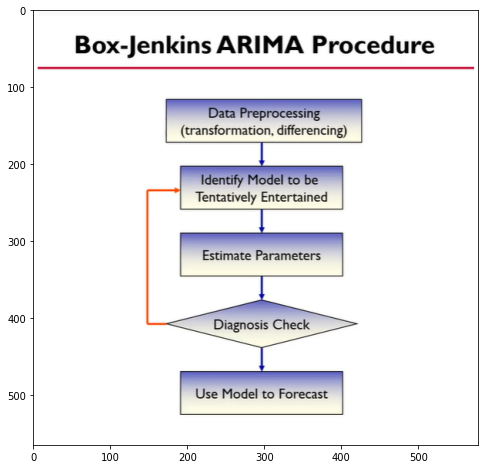

In [45]:
img = plt.imread('이미지 파일/ARIMA Procedure.png')
plt.figure(figsize = (18,8))
plt.imshow(img)

1. 데이터 전처리 (데이터가 nonstationary일 때, transformation이나 differencing을 이용해서 stationary하게 만듦)
2. 시범적으로 해볼 모델을 선정
3. 파라미터 추정
4. 모델이 괜찮은지 체크 => 괜찮지 않다면 2번 스텝으로
5. 예측하기

# Road Data

In [3]:
df=pd.read_csv('https://raw.githubusercontent.com/sm-joo/sm-joo/master/DEXKOUS.csv', parse_dates=['DATE'], index_col='DATE')

In [4]:
df.columns =['KOUS']
df['KOUS'].replace('.', '', inplace =True)
df['KOUS'] = pd.to_numeric(df['KOUS'])
df['KOUS'].fillna(method = 'ffill', inplace = True)

<AxesSubplot:xlabel='DATE'>

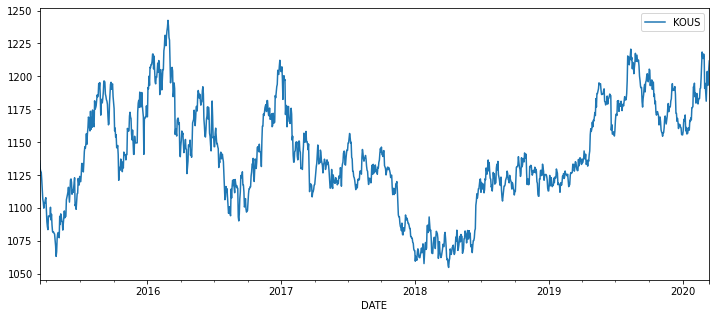

In [5]:
df.plot(figsize = (12, 5))

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1306 entries, 2015-03-13 to 2020-03-13
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   KOUS    1306 non-null   float64
dtypes: float64(1)
memory usage: 20.4 KB


2019년도만 살펴보자

In [7]:
df = df[(df.index>'2019-01-01') & (df.index < '2020-01-01')]

#  Stationary한 데이터 여부 확인하기

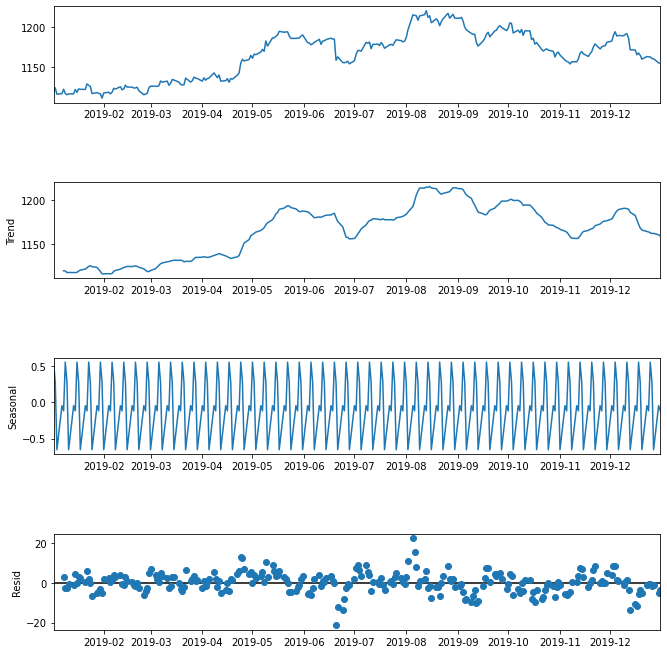

In [8]:
result = seasonal_decompose(df, model = 'additive', two_sided = False)
fig = result.plot()
fig.set_size_inches(10,10)
plt.show()

해당 기법을 어느정도 신뢰할 수 있을지 모르지만 계절성이 있고 5~6월과 7월의 잔차가 많아 보인다.

/Users/jeongseok/opt/anaconda3/envs/main/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


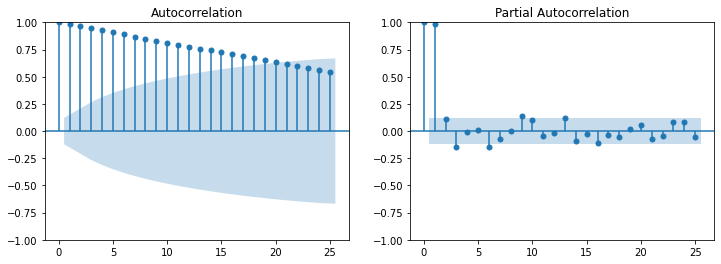

In [9]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 시각화
# subplot생성
fig, ax = plt.subplots(1,2 , figsize = (12,4))

# acf plot
plot_acf(df, ax = ax[0])

# pacf plot
plot_pacf(df, ax= ax[1])
plt.show()

두가지 도표를 추가로 확인해본 결과 정상성을 만족하지않는 nonstationary한 데이터인것같다.

# 데이터셋 분리

In [10]:
train_df, test_df = train_test_split(df, test_size = 0.2, shuffle = False)

# ARIMA(p,k,q) => k 결정

In [11]:
adfuller(train_df.KOUS)

(-1.5116465046171015,
 0.527742314043939,
 2,
 205,
 {'1%': -3.4626576734812318,
  '5%': -2.8757444215841326,
  '10%': -2.5743412314098753},
 1160.1362840640052)

위에서acf,pacf도표를 통해 non-stationary 하다는것을 확인했고 adfuller를통해 p-value까지 확인 해 보았다.


p-valuer가가 0.36으로 귀무가설이이 기각되지 않는다 -> 안정적이지 않다 따라서 차분이 필요하다

In [12]:
adfuller(train_df.KOUS.diff().dropna())

(-9.672174308592568,
 1.2683068272424294e-16,
 1,
 205,
 {'1%': -3.4626576734812318,
  '5%': -2.8757444215841326,
  '10%': -2.5743412314098753},
 1154.8592888585188)

In [13]:
diff_train_df = train_df.KOUS.diff().dropna()

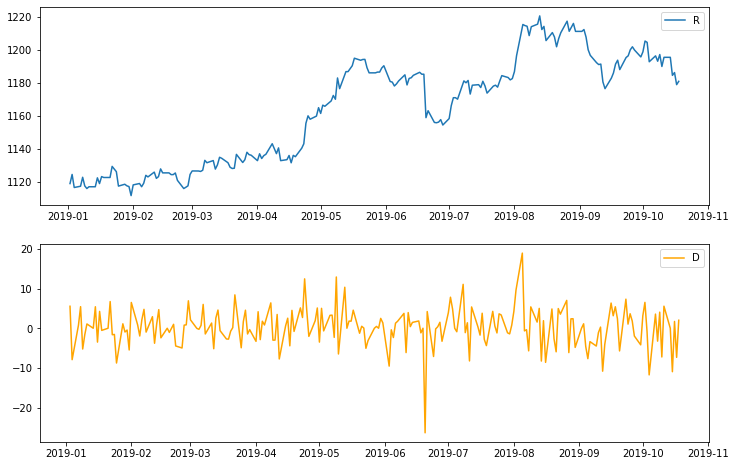

In [14]:
plt.figure(figsize= (12,8))
plt.subplot(211)
plt.plot(train_df)
plt.legend('RawData')
plt.subplot(212)
plt.plot(diff_train_df, 'orange')
plt.legend('DifferencedData')
plt.show()

1회 차분했을때 평균과 분산이 훨씬 좋아진모습이다.

/Users/jeongseok/opt/anaconda3/envs/main/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


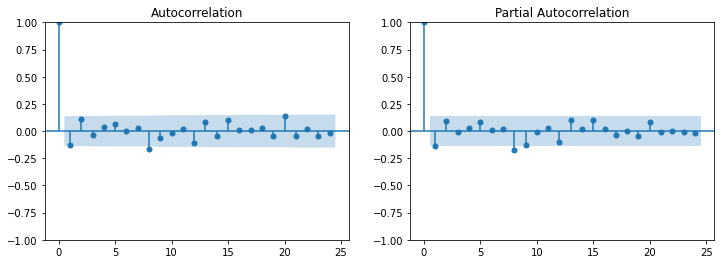

In [15]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 시각화
# subplot생성
fig, ax = plt.subplots(1,2 , figsize = (12,4))

# acf plot
plot_acf(diff_train_df, ax = ax[0])

# pacf plot
plot_pacf(diff_train_df, ax= ax[1])
plt.show()

acf도표와, pacf도표또한 훨씬 안정적인 모양이다.

/Users/jeongseok/opt/anaconda3/envs/main/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/Users/jeongseok/opt/anaconda3/envs/main/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


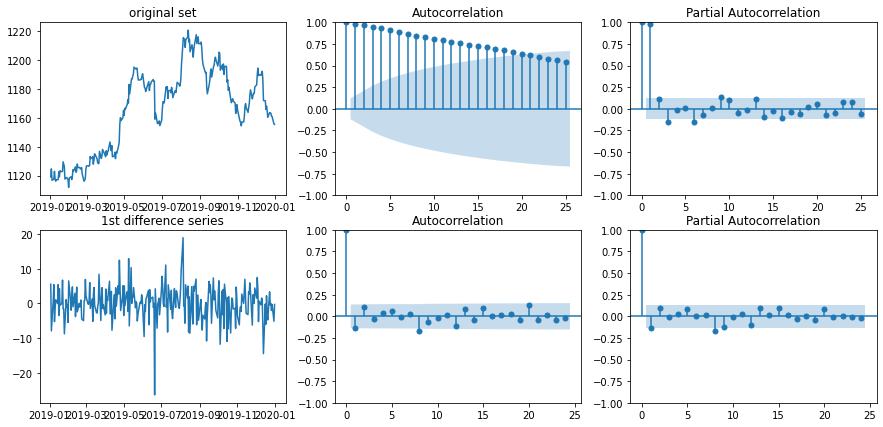

In [16]:
figure, axes =plt.subplots(2, 3, figsize =(15,7))
axes[0,0].plot(df.KOUS)
axes[0,0].set_title('original set')
axes[1,0].plot(df.KOUS.diff())
axes[1,0].set_title('1st difference series')
plot_acf(df.KOUS, axes[0,1])
plot_pacf(df.KOUS, axes[0,2])
plot_acf(diff_train_df, axes[1,1])
plot_pacf(diff_train_df, axes[1,2])
plt.show()

# 파라미터 추정(ARIMA(p,k,q) => p, q 결정)

ARIMA 모델의 잘 알려진 일부 예
- ARIMA(0,0,0)는 백색잡음 모델입니다.
- ARIMA(0,1,0)은 확률보행모델이며, 0이아닌 상수로 구성된 ARIMA(0,1,0)은 표류가 있는 확률보행입니다.
- ARIMA(0,1,1,)는 지수평활 모델이고, ARIMA(0,2,2)는 지수평활추세를 가진 데이터로 확장시킨 홀트의 선형 방법과 같다.(추세를 기반으로 한 예측에 사용될 수 있다.)
- ARIMA(p,0,0) 은 자기회귀 모델, ARIMA(0,0,q)는 이동평균이다.

< 백색잡음 모델 >
- 자기상관(autocorrelation)이 없는 시계열을 백색 잡음(white noise)라고 부른다.
- 자기상관함수(ACF)도표를 통해서 확인해 보면 모두 상관관계가 없는것을 확인해 볼수 있다.
- 시계열 데이터 통계분석에서 백색잡음과정(white noise process) 는 평균이0, 분산이 유한한 상수(sigma^2)인 확률분포로 부터 서로 상관되지 않게 무작위로 샘플을 추출한 신호를 말한다.
- 강한 정상성을 가지고 있는데이터 이다. 

< 확률보행(Random Walk) >
- 확률보행과정은 백색잡음과 달리 '비정상성'을 가지고 있는 데이터이다. 따라서 ARIMA모델에 적용시키기 위해서는 정상화 시켜야하는데 확률보행은 상수가 있는것과 없는것으로 나누어져 있다. 
- 확률보행의 경우 임의의 방향으로 향하는 연속적인 걸음을 나타내는 의미로, 예측 불가능한 변동이 발생하는 것을 뜻한다. 예를들어 위로갈 확률이 0.3 아래로갈 확률이 0.7일경우 주식차트처럼 오르락 내리락 할것이다.




## Graphical method를를 통해 계략적인 파라미터 추정

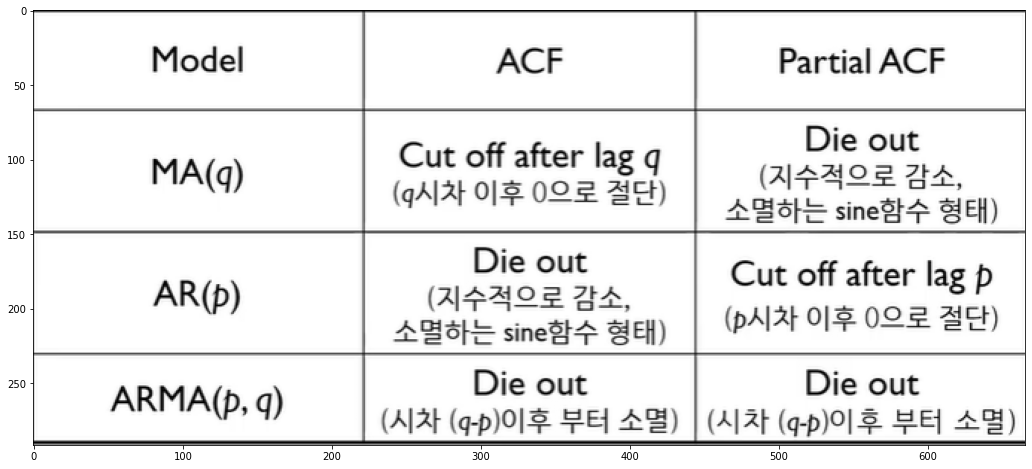

In [17]:
img2 = plt.imread('./이미지 파일/Graphical_method.png')
plt.figure(figsize =(18,8))
plt.imshow(img2)

ACF는 1시차 이후로 0으로 절단하고 천천히감소, PACF역시 1시차 이후로 0후로감소하고 천천히 감소하므로 MA, AR모두 해당한다. 그리고 ARMA모델의 설명역시 맞는것같다 1로정했지만 0이라고 봐도 무방한 정도이므로..

정리해보면, 차분은 1회 d = 1, ARMA(1,1)모델을 사용해서 먼저 시범모델을 만들어서 확인해보자

# ARIMA 예측 모델링


파라미터 설명
- order : AR차수, 차분횟수, MA차수
- freq : 날짜 

    'B' - business day, ie., Mon. - Fri.
    'D' - daily
    'W' - weekly
    'M' - monthly
    'A' - annual
    'Q' - quarterly
- trend : 상수항 포함여부, 'c'(constant) or 'nc'(no constant) -> 'c'를 했을때 constant가 0.05보다 크게나온다면 nc를 하는게 좋다. 

In [18]:
model =ARIMA(diff_train_df, order = (1,1,1), freq = 'B')
model_fit = model.fit()
model_fit.summary()

/Users/jeongseok/opt/anaconda3/envs/main/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   KOUS   No. Observations:                  207
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -621.063
Date:                Wed, 13 Jul 2022   AIC                           1248.126
Time:                        22:25:20   BIC                           1258.110
Sample:                    01-03-2019   HQIC                          1252.164
                         - 10-18-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1280      0.085     -1.501      0.133      -0.295       0.039
ma.L1         -0.9997      0.688     -1.453      0.146      -2.348       0.349
sigma2        23.6895     15.959      1.484      0.138      -7.589      54.968
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):               205.39
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               2.26   Skew:                            -0.58
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

해당 모델을 돌려보니 AR과 MA 둘다 p-value값이 0.05보다 크게나온다. 즉 정상성을 만족하지 못하므로 다른모델을 찾아봐야한다.

## 더 좋은 파라미터 찾기

In [19]:
# Parameter search

p = range(0,3)
d = range(1,2)
q = range(0,3)
pdq = list(itertools.product(p, d,q))

aic = []
for i in pdq:
    model = ARIMA(diff_train_df, order = (i))
    model_fit = model.fit()
    print(f'ARIMA: {i} >> AIC : {round(model_fit.aic,2)}')
    aic.append(round(model_fit.aic,2))

/Users/jeongseok/opt/anaconda3/envs/main/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/jeongseok/opt/anaconda3/envs/main/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/jeongseok/opt/anaconda3/envs/main/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/jeongseok/opt/anaconda3/envs/main/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/jeongseok/opt/anaconda3/envs/main/lib/python3.8/site-packages/statsmo

ARIMA: (0, 1, 0) >> AIC : 1409.96
ARIMA: (0, 1, 1) >> AIC : 1249.51
ARIMA: (0, 1, 2) >> AIC : 1248.73
ARIMA: (1, 1, 0) >> AIC : 1317.2
ARIMA: (1, 1, 1) >> AIC : 1248.13
ARIMA: (1, 1, 2) >> AIC : 1248.53
ARIMA: (2, 1, 0) >> AIC : 1298.6


/Users/jeongseok/opt/anaconda3/envs/main/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/jeongseok/opt/anaconda3/envs/main/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/jeongseok/opt/anaconda3/envs/main/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/jeongseok/opt/anaconda3/envs/main/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/jeongseok/opt/anaconda3/envs/main/lib/python3.8/site-packages/statsmo

ARIMA: (2, 1, 1) >> AIC : 1247.96
ARIMA: (2, 1, 2) >> AIC : 1249.95


/Users/jeongseok/opt/anaconda3/envs/main/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/jeongseok/opt/anaconda3/envs/main/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/jeongseok/opt/anaconda3/envs/main/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


In [20]:
# Search optimal parameters
optimal = [(pdq[i],j) for i, j in enumerate(aic) if j == min(aic)]
optimal

[((2, 1, 1), 1247.96)]

In [21]:
model =ARIMA(diff_train_df, order = (2,1,1), freq = 'B')
model_fit = model.fit()
model_fit.summary()

/Users/jeongseok/opt/anaconda3/envs/main/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   KOUS   No. Observations:                  207
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -619.981
Date:                Wed, 13 Jul 2022   AIC                           1247.962
Time:                        22:25:38   BIC                           1261.273
Sample:                    01-03-2019   HQIC                          1253.345
                         - 10-18-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1149      0.088     -1.309      0.191      -0.287       0.057
ar.L2          0.1035      0.082      1.262      0.207      -0.057       0.264
ma.L1         -0.9998      1.176     -0.850      0.395      -3.305       1.306
sigma2        23.4616     27.268      0.860      0.390     -29.982      76.906
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               195.46
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               2.18   Skew:                            -0.60
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

< summary 해석 >
- AR
  - coef :  환율이 한번 튀었을때 다음 차수 그다음차수 3차수까지 3번은 환율이 떨어진다
- mA
  - coef : 외부에서 충격이 왔을때  올라가는 충격이 왔을때 2차수 정도 올라가는 충격이 지속된다.
- p-value 
  - 0.05보다 작아야지 안정성이 있으므로 AR(3)은 제외

In [ ]:
def my_auto_arima(data, order, sort='AIC'):
    order_list = []
    aic_list = []
    bic_lsit = []

    for p in range(order[0]):
        for d in range(order[2]):
            for q in range(order[2]):
                model = ARIMA(data, order=(p, d, q), freq = 'B')

                try:
                    model_fit = model.fit(trend='nc')
                    c_order = f'p{p} d{d} q{q}'
                    aic = model_fit.aic
                    bic = model_fit.bic
                    order_list.append(c_order)
                    aic_list.append(aic)
                    bic_list.append(bic)
                except:
                    pass

                result_df = pd.DataFrame(list(zip(order_list, aic_list)),
                                         columns=['order', 'AIC'])
                result_df.sort_values(sort, inplace=True)

    return result_df
my_auto_arima(df['KOUS'], [3,1,3])

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


,order,AIC
11,p2 d1 q0,1545.578949
3,p0 d1 q2,1546.030324
6,p1 d1 q0,1546.362545
2,p0 d1 q1,1546.691467
12,p2 d1 q1,1547.530062
15,p2 d2 q1,1547.930234
13,p2 d1 q2,1548.416207
4,p0 d2 q1,1548.522292
8,p1 d2 q1,1548.592138
9,p1 d2 q2,1548.844002


In [ ]:
model = ARIMA(df.KOUS, order = (2,1,0), freq = 'B')
model_fit = model.fit(trend = 'nc')
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                 D.KOUS   No. Observations:                  259
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -769.789
Method:                       css-mle   S.D. of innovations              4.726
Date:                Wed, 06 Jul 2022   AIC                           1545.579
Time:                        13:55:17   BIC                           1556.249
Sample:                    01-03-2019   HQIC                          1549.869
                         - 12-31-2019                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
ar.L1.D.KOUS    -0.0772      0.062     -1.250      0.212      -0.198       0.044
ar.L2.D.KOUS     0.1040      0.062      1.673      0.096      -0.018       0.226
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.7519           +0.0000j            2.7519            0.5000
AR.2            3.4944           +0.0000j            3.4944            0.0000
-----------------------------------------------------------------------------
"""

In [ ]:
model = ARIMA(df.KOUS, order = (2,1,2), freq = 'B')
model_fit = model.fit(trend = 'nc')
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                 D.KOUS   No. Observations:                  259
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -769.208
Method:                       css-mle   S.D. of innovations              4.715
Date:                Wed, 06 Jul 2022   AIC                           1548.416
Time:                        13:54:58   BIC                           1566.200
Sample:                    01-03-2019   HQIC                          1555.566
                         - 12-31-2019                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
ar.L1.D.KOUS    -1.2447      0.243     -5.123      0.000      -1.721      -0.768
ar.L2.D.KOUS    -0.7340      0.257     -2.851      0.005      -1.239      -0.229
ma.L1.D.KOUS     1.1778      0.245      4.802      0.000       0.697       1.658
ma.L2.D.KOUS     0.7424      0.254      2.923      0.004       0.245       1.240
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.8479           -0.8022j            1.1672           -0.3794
AR.2           -0.8479           +0.8022j            1.1672            0.3794
MA.1           -0.7932           -0.8472j            1.1606           -0.3698
MA.2           -0.7932           +0.8472j            1.1606            0.3698
-----------------------------------------------------------------------------
"""

분명히 루프를 돌릴때는 2,1,0 이 가장AIC기준 가장 좋은 파라미터 였지만 p-value값이 이상하다..

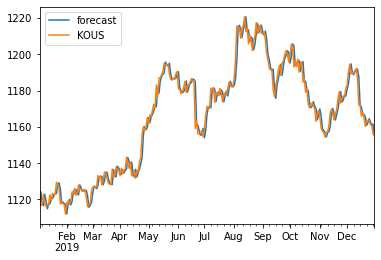

In [ ]:
# 전혀의미없지만 이런함수도 있다. 학습한데이터와 같은 데이터를 테스트로 돌려서 예측 plot을 그리는것인데 의미가....
model_fit.plot_predict()
plt.show()

# train/ test split

arima계열 데이터는 데이터가 너무많으면 예측하기에 별로안좋다??

In [ ]:
train = df.iloc[0:30]
test = df.iloc[30:35]

In [ ]:
model = ARIMA(train, order = (2,1,2), freq = 'B')
model_fit = model.fit(trend = 'nc')
model_fit.forecast(5, alpha = 0.05)

(array([1122.71126571, 1123.35492383, 1123.72752319, 1123.72485447,
        1123.51270791]),
 array([3.55653204, 4.20720366, 4.80873165, 5.7449708 , 6.93432529]),
 array([[1115.740591  , 1129.68194043],
        [1115.10895618, 1131.60089147],
        [1114.30258234, 1133.15246404],
        [1112.46491861, 1134.98479032],
        [1109.92168007, 1137.10373574]]))

첫 번째 array : 예측 값

두 번째 array : 표준에러

세 번째 array : 신뢰구간 [하한, 상한]

In [ ]:
fc, se, coef = model_fit.forecast(5, alpha = 0.05)

In [ ]:
# 예측값 인덱스 넣기
fc_data = pd.Series(fc, index = test.index)

# 신뢰구간 인덱스 넣기
lower_data = pd.Series(coef[:,0], index = test.index)
upper_data = pd.Series(coef[:,1], index = test.index )

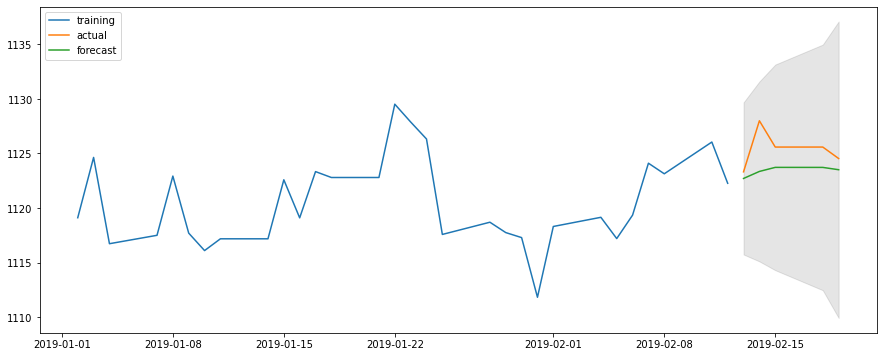

In [ ]:
# VIZ
plt.figure(figsize =(15, 6))
plt.plot(train, label = 'training')
plt.plot(test, label = 'actual')
plt.plot(fc_data, label = 'forecast')
plt.fill_between(test.index, lower_data, upper_data, color = 'black', alpha = 0.1)
plt.legend(loc = 'upper left')
plt.show()

ARIMA 모형의 한계는 기존의 패턴으로 예측하기에 외부 요인으로 튄경우를 예측하지 못하는데 VAR(Vector Auto Regression)같은 모델을 활용하여 Multivariate time series forecasting 을 해야한다.